# NetColoc Reproducibility Notebook

Figures generated:
- Figure 3A
- Figure 3B
- Figure 3C
- Figure 3D
- Figure 3E
- Figure 3F
- SFig 1A
- SFig 1B
- SFig 1C


### Set Up

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import hypergeom
import obonet as obo
import re
from tqdm import tqdm
import re
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import mannwhitneyu

In [3]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [5]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

blue='#63c1e0'
green='#5fad56'
purple = '#8d3b72'
darkpurple='#441f5d'

## Load NetColoc Results

In [6]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [7]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
initial_df = coloc_df[coloc_df['Analysis Set']=='Initial'].copy()
repeat_df = coloc_df[coloc_df['Analysis Set']=='Additional'].copy()

In [8]:
repeat_df.EFO.nunique()

223

In [9]:
repeat_df.columns

Index(['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',
       'Optimal COLOC', 'Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN', 'COLOC -logp HN',
       'Observed Size ST', 'Expected Size ST', 'Log2SizeOE ST',
       'COLOC Score ST', 'COLOC P ST', 'COLOC -logp ST', 'trait_pair'],
      dtype='object')

In [10]:
repeat_df['q'] = fdrcorrection(repeat_df['COLOC p'])[1]

In [12]:
initial_df['q'] = fdrcorrection(initial_df['COLOC p'])[1]

In [13]:
all_df = pd.concat([initial_df, repeat_df], axis=0)

In [14]:
all_df['logq'] = all_df.q.apply(lambda x: -1 * np.log10(x+1e-250))

### Additional metadata

In [43]:
info_df = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
info_df.columns = ['TRAIT', 'EFO', 'trait_type', 'Domain']

In [88]:
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

## Figure 3A - Replicate counts

In [15]:
trait_counts = all_df.groupby('EFO').trait_pair.nunique().reset_index()
repeat_traits = trait_counts[trait_counts.trait_pair > 1]

In [16]:
len(repeat_traits)

223

In [19]:
all_df['TraitR'] = all_df['Rare Study'].astype(int).astype(str) + '_' + all_df['EFO']
all_df['TraitC'] = all_df['Common Study'] + '_' + all_df['EFO']

In [20]:
repeat_plot_df = pd.DataFrame({'TraitR': all_df[all_df.EFO.isin(repeat_traits.EFO.values)].groupby('EFO').TraitR.nunique(),
                                'TraitC': all_df[all_df.EFO.isin(repeat_traits.EFO.values)].groupby('EFO').TraitC.nunique()})

repeat_plot_df = repeat_plot_df.melt(var_name='Trait', value_name='Count')
repeat_plot_df['Trait'] = repeat_plot_df['Trait'].replace({'TraitR': 'Rare', 'TraitC': 'Common'})

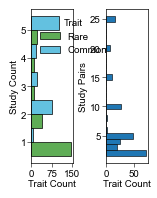

In [22]:
_, [ax1, ax2] = plt.subplots(figsize=(1.5, 2), nrows=1, ncols=2, gridspec_kw={'wspace': 0.8})
sns.histplot(repeat_plot_df,y='Count', hue='Trait', discrete=True, multiple='dodge', palette=[green, blue], alpha=1, ax=ax1)
sns.histplot(repeat_traits, y='trait_pair', discrete=True, alpha=1, ax=ax2)
_ = ax1.set_xticks([0, 75, 150])
ax1.set_ylabel('Study Count')
ax2.set_ylabel('Study Pairs')
for ax in [ax1, ax2]:
    ax.set_xlabel('Trait Count')



## Figure 3B

In [40]:
info_df.loc[:, ('EFO', 'trait_type')]

,EFO,trait_type
0,neutrophil count,EFO_0004833
3,autism spectrum disorder,EFO_0003756
5,gastroesophageal reflux disease,EFO_0003948
6,hypothyroidism,EFO_0004705
7,Barrett's esophagus,EFO_0000280
...,...,...
747,nephrolithiasis,EFO_0004253
748,congenital left-sided heart lesions,EFO_0005938
749,neoplasm of mature b-cells,EFO_0000096
750,osteitis deformans,EFO_0004261


In [45]:
test_df = all_df[all_df.EFO.isin(repeat_traits.EFO.values)].copy()
original_vals= test_df[test_df['Analysis Set']== 'Initial'].set_index('EFO').Log2SizeOE
repeat_vals= test_df[test_df['Analysis Set']== 'Additional'].set_index('EFO').groupby('EFO').Log2SizeOE.mean()
repeat_count = test_df[test_df['Analysis Set']== 'Additional'].set_index('EFO').groupby('EFO').Log2SizeOE.count()
plot_df = pd.DataFrame({'original': original_vals, 'repeat': repeat_vals, 'count': repeat_count}).reset_index()
plot_df = plot_df.merge(info_df.loc[:, ('EFO', 'trait_type')], on='EFO', how='left').drop_duplicates(subset=['EFO'])

Text(0.2, 0.9, 'r = 0.84')

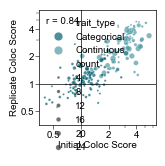

In [48]:
_ = plt.figure(figsize=(1.5,1.5))
sns.scatterplot(plot_df, x='original', y='repeat', size='count', alpha=0.7, hue='trait_type', palette=['#00606f', '#509aa5'], 
                        hue_order=['Categorical', 'Continuous'], sizes=(2, 15))
plot_df.corr(method='spearman', numeric_only=True)
ax1 = plt.gca()
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_xticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_xticks(np.log2([3,5,6]), minor=True)
ax1.hlines(y=0, xmin=-1.5, xmax=3, color='black', linewidth=0.5, zorder=6)
ax1.vlines(x=0, ymin=-1.5, ymax=3, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-1.5, 2.7)
ax1.set_ylim(-1.5, 2.7)
ax1.set_xlabel('Initial Coloc Score')
ax1.set_ylabel('Replicate Coloc Score')
r = plot_df.corr(method='spearman', numeric_only=True).at['original', 'repeat']
ax1.text(0.2, 0.9, f'r = {r:.2f}', transform=ax1.transAxes, ha='center', va='center')


## SFig 1A

In [50]:
final_df = test_df.copy()
final_df = final_df.merge(info_df, on='EFO')

In [51]:
def assign_study_numbers(df):
    df = df.copy()
    df['TraitR_num'] = 0
    df['TraitC_num'] = 0

    for efo in df['EFO'].unique():
        # Get subset for this EFO
        efo_mask = df['EFO'] == efo
        study_r = df[efo_mask]['TraitR'].unique()
        study_c = df[efo_mask]['TraitC'].unique()
        r_dict = {study: i+1 for i, study in enumerate(study_r)}
        c_dict = {study: i+1 for i, study in enumerate(study_c)}

        df.loc[efo_mask, 'TraitR_num'] = df.loc[efo_mask, 'TraitR'].map(r_dict)
        df.loc[efo_mask, 'TraitC_num'] = df.loc[efo_mask, 'TraitC'].map(c_dict)
    
    return df

final_df = assign_study_numbers(final_df)

In [52]:
cc_counts = final_df[final_df.trait_type=='Categorical'].groupby('EFO').trait_pair.nunique().reset_index()
q_counts = final_df[final_df.trait_type=='Continuous'].groupby('EFO').trait_pair.nunique().reset_index()


In [53]:
top_cc = cc_counts[cc_counts.trait_pair>=10].EFO.values
top_qq = q_counts[q_counts.trait_pair>=20].EFO.values

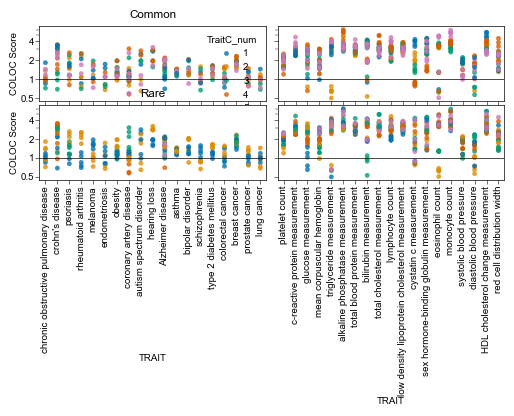

In [54]:
full_palette = sns.color_palette("colorblind", 10)
palette1 = full_palette[:5] #[full_palette[x] for x in [0,3,4,6,8]]
palette2= palette1#full_palette[5:]#[full_palette[x] for x in [1,2,5,7,9]]

_, [[ax1, ax3], [ax2, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,2), gridspec_kw={'wspace': 0.05, 'hspace': 0.05}, 
sharey=True, sharex='col')
sns.scatterplot(final_df[final_df.EFO.isin(top_cc)], x='TRAIT', y='Log2SizeOE', hue='TraitC_num',#jitter=0, 
alpha=0.8, palette=palette1, ax=ax1, edgecolor=None, s=10)
sns.scatterplot(final_df[final_df.EFO.isin(top_cc)], x='TRAIT', y='Log2SizeOE',  hue='TraitR_num',#jitter=0, 
alpha=0.8, palette=palette2, ax=ax2, edgecolor=None, s=10, legend=False)

sns.scatterplot(final_df[final_df.EFO.isin(top_qq)], x='TRAIT', y='Log2SizeOE', hue='TraitC_num',#jitter=0, 
alpha=0.8, palette=palette1, ax=ax3, edgecolor=None, s=10, legend=False)
sns.scatterplot(final_df[final_df.EFO.isin(top_qq)], x='TRAIT', y='Log2SizeOE',  hue='TraitR_num',#jitter=0, 
alpha=0.8, palette=palette2, ax=ax4, edgecolor=None, s=10, legend=False)

for ax in [ax1, ax2]:
    ax.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
    ax.set_yticks([np.log2(x) for x in [3,5,6]], minor=True)
    ax.set_ylabel('COLOC Score')
    
for ax in [ax1, ax2, ax3, ax4]:
    ax.hlines(y=0, xmin=-0.5, xmax=18.5, color='black', linewidth=0.5, zorder=6)
    ax.set_xlim(-0.5, 18.5)
    ax.tick_params(axis='x', rotation=90)

ax1.set_title('Common')
ax2.set_title('Rare')
ax1.set_xlabel('Categorical Traits')
ax3.set_xlabel('Continuous Traits')

## Figure 3C

In [55]:
c_efos =['EFO_0001065', 'EFO_0000384', 'EFO_0004530', 'EFO_0004617']
r_efos = ['MONDO_0005090', 'EFO_0004842', 'EFO_0001645', 'EFO_0004468']

In [56]:
# Assign ordered study numbers
r_studies = {}
c_studies = {}
for t in final_df.TRAIT.values:
    use_df = final_df[final_df.TRAIT==t].sort_values('Log2SizeOE', ascending=True)
    rare_order = use_df.groupby('TraitR').Log2SizeOE.mean().sort_values().index.values
    r = 1
    for study in rare_order:
        r_studies[study] = r
        r +=1
        
    common_order = use_df.groupby('TraitC').Log2SizeOE.mean().sort_values().index.values
    c=1
    for study in common_order:
        c_studies[study] = c
        c +=1



In [57]:
final_df = final_df.assign(plotR = final_df.TraitR.map(r_studies), plotC= final_df.TraitC.map(c_studies))

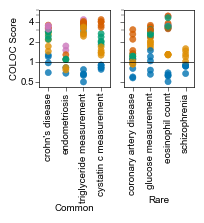

In [59]:
_ , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2, 1), sharey=True)
sns.scatterplot(final_df[final_df.EFO.isin(c_efos)], x='TRAIT', y='Log2SizeOE', hue='plotC',#jitter=0, 
alpha=0.8, palette=palette1, ax=ax1, edgecolor=None, s=20, legend=False)
sns.scatterplot(final_df[final_df.EFO.isin(r_efos)], x='TRAIT', y='Log2SizeOE', hue='plotR',#jitter=0, 
alpha=0.8, palette=palette1, ax=ax2, edgecolor=None, s=20, legend=False)

for ax in [ax1, ax2]:
    ax.hlines(y=0, xmin=-0.5, xmax=3.5, color='black', linewidth=0.5)
    ax.set_xlim(-0.5, 3.5)
    ax.tick_params(axis='x', rotation=90)
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax1.set_ylabel('COLOC Score')
ax1.set_ylim(-1.25, np.log2(6))
_ = ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks([np.log2(3), np.log2(5), np.log2(6)], minor=True)


## SFig 1B

In [60]:
best_df = all_df.sort_values(by='Log2SizeOE', ascending=False).drop_duplicates(subset=['EFO'])

In [61]:
trait_counts = all_df.EFO.value_counts().reset_index()
best_df = best_df.merge(trait_counts, on='EFO', how='left')

In [62]:
best_df['bonf_q'] = best_df.apply(lambda z : min([1, z.q * z['count']]), axis=1)
best_df['logq'] = -np.log10(best_df.bonf_q + 1e-250)

<Axes: >

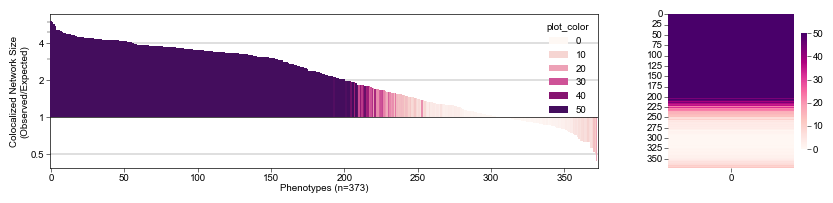

In [63]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10, 2), gridspec_kw={'width_ratios':[7,2]})

best_df['plot_color'] = best_df.logq.apply(lambda z: min(z, 50))
sns.barplot(best_df.sort_values(by='Log2SizeOE', ascending=False), x='trait_pair', y='Log2SizeOE', hue='plot_color', 
            palette='RdPu', width=1, zorder=5, ax=ax1)
_ = ax1.set_xticks([])
ax1.hlines(y=[-1, 1,2], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=2)
#ax1.hlines(y=[-1*np.log2(1.3), np.log2(1.3),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.3, 
#           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=373.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.75, 372.75)

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_ylabel('Colocalized Network Size\n(Observed/Expected)')
ax1.set_xlabel(f'Phenotypes (n={len(best_df)})')
ax1.set_xticks([0, 50, 100, 150, 200, 250, 300, 350], labels = [0, 50, 100, 150, 200, 250, 300, 350])
sns.heatmap(best_df.plot_color.values.reshape(373, 1), cmap='RdPu', cbar_kws={'shrink':0.75})


In [64]:
best_sig = best_df[(best_df.bonf_q<0.05) & (best_df.Log2SizeOE> 0)]

In [65]:
print('Final colocalized traits:', len(best_sig))

Final colocalized traits: 283


In [68]:
len(best_df[(best_df.bonf_q<0.05) & (best_df.Log2SizeOE> 0) & (best_df.nShared==0)])

84

## Figure 3D

In [71]:
changed = best_df[best_df['Analysis Set']=='Additional']
original_df = all_df[all_df['Analysis Set']=='Initial'].loc[:, ['EFO', 'Log2SizeOE']].rename(columns={'Log2SizeOE':'prior'})
changed = changed.merge(original_df, on='EFO', how='left').drop_duplicates()
changed = changed.merge(info_df.loc[:, ['EFO', 'trait_type']], on='EFO', how='left').drop_duplicates()


In [73]:
all_df = all_df.merge(info_df.loc[:, ['EFO', 'trait_type']], on='EFO', how='left').drop_duplicates()
all_df[all_df['Analysis Set']=='Additional'].drop_duplicates(subset=['EFO']).trait_type.value_counts()


trait_type
Categorical    114
Continuous     109
Name: count, dtype: int64

In [78]:
changed

,EFO,Trait,Common Study,Rare Study,Analysis Set,nCommon,nRare,nShared,pShared,Network,...,q,logq,TraitR,TraitC,count,bonf_q,plot_color,prior,trait_type,diff
0,EFO_0004533,alkaline phosphatase measurement,GCST90025947,34375979,Additional,16,8,6,5.163822e-22,PCNet2.0,...,0.000000e+00,250.000000,34375979_EFO_0004533,GCST90025947_EFO_0004533,25,0.000000e+00,50.000000,1.750428,Continuous,0.858642
1,EFO_0005091,monocyte count,GCST90025950,34662886,Additional,16,12,7,1.512394e-23,PCNet2.0,...,0.000000e+00,250.000000,34662886_EFO_0005091,GCST90025950_EFO_0005091,25,0.000000e+00,50.000000,1.658722,Continuous,0.925930
2,EFO_0006925,lipoprotein A measurement,GCST90019513,36088354,Additional,23,12,11,2.936327e-37,PCNet2.0,...,0.000000e+00,250.000000,36088354_EFO_0006925,GCST90019513_EFO_0006925,15,0.000000e+00,50.000000,2.087243,Continuous,0.454088
3,EFO_0007805,HDL cholesterol change measurement,GCST90025956,34662886,Additional,22,25,14,4.811871e-41,PCNet2.0,...,0.000000e+00,250.000000,34662886_EFO_0007805,GCST90025956_EFO_0007805,25,0.000000e+00,50.000000,2.461409,Continuous,0.013418
4,EFO_0004531,urate measurement,GCST90025965,36088354,Additional,15,5,3,1.256711e-12,PCNet2.0,...,0.000000e+00,250.000000,36088354_EFO_0004531,GCST90025965_EFO_0004531,5,0.000000e+00,50.000000,2.346798,Continuous,0.029099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,EFO_0000555,irritable bowel syndrome,GCST006304,34375979,Additional,4,33,0,6.929835e-03,PCNet2.0,...,3.451337e-02,0.984891,34375979_EFO_0000555,GCST006304_EFO_0000555,3,1.035401e-01,0.984891,-0.444680,Categorical,0.217165
164,EFO_0001422,cirrhosis of liver,GCST90018826,34375979,Additional,3,15,0,2.366676e-03,PCNet2.0,...,8.615804e-04,2.587583,34375979_EFO_0001422,GCST90018826_EFO_0001422,3,2.584741e-03,2.587583,-1.304546,Categorical,0.972036
165,EFO_0003762,vitamin D deficiency,GCST90020244,34375979,Additional,9,13,0,6.142358e-03,PCNet2.0,...,5.053939e-04,2.995340,34375979_EFO_0003762,GCST90020244_EFO_0003762,2,1.010788e-03,2.995340,-0.629905,Categorical,0.248689
166,EFO_0000280,Barrett's esophagus,GCST003738,34375979,Additional,4,12,0,2.524123e-03,PCNet2.0,...,1.434507e-07,6.241237,34375979_EFO_0000280,GCST003738_EFO_0000280,4,5.738028e-07,6.241237,-1.036136,Categorical,0.558741


Text(0.5, 6.055555555555554, 'Traits with impoved\nCOLOC Score')

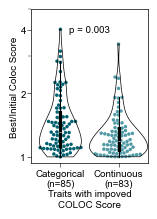

In [79]:
_ = plt.figure(figsize=(1.5,2))
changed['diff'] = changed.Log2SizeOE - changed.prior
sns.violinplot(changed, y='diff', x='trait_type', cut=0, saturation=1, fill=False, color='black', linewidth=0.5, zorder=2, 
               order=['Categorical', 'Continuous'], width=1)
sns.swarmplot(changed, y='diff', x='trait_type', s=2.5, hue='trait_type', palette=['#00606F', '#509aa5'], 
              hue_order=['Categorical', 'Continuous'], 
order=['Categorical', 'Continuous'], zorder=1)
ax = plt.gca()
ax.set_yticks([0, 1, 2], [1, 2, 4])
ax.set_yticks([np.log2(3), np.log2(5)], minor=True)
n_cc = len(changed[changed.trait_type=="Categorical"])
n_q = len(changed[changed.trait_type=="Continuous"])
_ = ax.set_ylabel('Best/Initial Coloc Score')
_ = ax.set_xticks([0,1], [f'Continuous\n(n={n_q})', f'Categorical\n(n={n_cc})'][::-1])
p = mannwhitneyu(changed[changed.trait_type=='Categorical']['diff'].values, 
                 changed[changed.trait_type=='Continuous']['diff'].values).pvalue
ax.text(0.5, 2, f'p = {p:.3f}', ha='center', va='center')
ax.set_xlabel('Traits with impoved\nCOLOC Score')

## Figure 3E - Prioritized Genes

In [80]:
def load_z(trait, datadir, transform, norm, rorc):
    df = pd.read_csv(os.path.join(datadir, f'{trait}_z_{rorc}V_q_{transform}_{norm}.tsv'), sep='\t', header=None,
                    index_col=0, names=['z']).dropna()
    return df

## Load all_zscores
def load_all_scores(df, datadir, rorc):
    allz = {}
    if rorc == 'C':
        other = 'TraitR'
    else:
        other = 'TraitC'
    for i, t in tqdm(enumerate(list(df[f'Trait{rorc}'].values))):
        if rorc == 'R':
            other = 'TraitC'
            allz[f'{t}_{df[other].values[i]}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
        else:
            other = 'TraitR'
            allz[f'{df[other].values[i]}_{t}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
    z = pd.DataFrame.from_dict(allz)
    return z

In [81]:
nrnb_dir = '/cellar/users/snwright/Data/RareCommon'

In [82]:
zR = load_all_scores(best_df, os.path.join(nrnb_dir, 'outputs/netcoloc/March_2025'), 'R').dropna()
zC = load_all_scores(best_df, os.path.join(nrnb_dir, 'outputs/netcoloc/March_2025'), 'C').dropna()
z_coloc = zR * zC

373it [00:03, 99.78it/s] 
373it [00:03, 108.38it/s]


In [84]:
## Load genes
def load_genes(trait, rorc, indir=os.path.join(nrnb_dir, 'inputs/March_2025')):
    genes = pd.read_csv(os.path.join(indir, trait+f'_{rorc}V.txt'), sep='\t')
    return genes['Entrez'].unique()

network_genes = list(z_coloc.index.values)
rare_genes = {t: [x for x in load_genes(t, 'R') if x in network_genes] for t in tqdm(best_df.TraitR.unique())}
common_genes = {t: [x for x in load_genes(t, 'C') if x in network_genes] for t in tqdm(best_df.TraitC.unique())}



100%|██████████| 373/373 [00:01<00:00, 275.87it/s]

100%|██████████| 373/373 [00:01<00:00, 290.59it/s]


In [85]:
trait_pairs = [x for x in zip(best_df.TraitR, best_df.TraitC)]

overlap_genes = {t:set(rare_genes[t[0]]).intersection(common_genes[t[1]]) for t in tqdm(trait_pairs)}
rare_only = {t:set(rare_genes[t[0]]).difference(common_genes[t[1]]) for t in tqdm(trait_pairs)}
common_only = {t:set(common_genes[t[1]]).difference(rare_genes[t[0]]) for t in tqdm(trait_pairs)}


100%|██████████| 373/373 [00:00<00:00, 258676.49it/s]

100%|██████████| 373/373 [00:00<00:00, 196468.09it/s]

100%|██████████| 373/373 [00:00<00:00, 287799.01it/s]


In [86]:
overlaps = {t[0]: len(overlap_genes[t]) for t in overlap_genes.keys()}
overlaps = [overlaps[x] for x in best_df[(best_df.bonf_q <0.05) & (best_df.Log2SizeOE > 0)].TraitR.values]

In [90]:
gene_splits = pd.DataFrame({'Overlap':[len(overlap_genes[x]) for x in trait_pairs], 
                           'RareOnly':[len(rare_only[x]) for x in trait_pairs],
                           'CommonOnly':[len(common_only[x]) for x in trait_pairs]}, index=trait_pairs)
gene_splits['TraitR'] = [t[0] for t in trait_pairs]
gene_splits['TraitC'] = [t[1] for t in trait_pairs]
gene_splits['EFO'] = gene_splits.TraitR.apply(lambda x: map_trait_code(x))

In [91]:
def get_single_z_support(idx, genes, data_df, th=3):
    trait_df = data_df.iloc[:, idx]
    gene_df = trait_df.loc[list(genes)]
    return np.sum(gene_df >= th)

def get_coloc_support(trait, genes, rare_df, common_df, th=3):
    trait_rare = rare_df[trait]
    trait_common = common_df[trait]
    trait_df = pd.DataFrame({'rare':trait_rare, 'common':trait_common}).loc[list(genes)]
    trait_df['coloc'] = trait_df.rare * trait_df.common
    return len(trait_df[(trait_df.coloc >= th) & (trait_df.rare > 1) & (trait_df.common > 1)])

def get_all_support(trait_pairs, rare_df, common_df, coloc_df):
    
    results = {'Overlap':{}, 'Rare':{}, 'Common':{}}
    for i, pair in tqdm(enumerate(trait_pairs)):
        for j, geneset in enumerate([overlap_genes[pair], rare_only[pair], common_only[pair]]):

            rare_n = get_single_z_support(i,geneset, rare_df, th=1)
            common_n = get_single_z_support(i,geneset, common_df, th=1)
            coloc_n = get_single_z_support(i,geneset,coloc_df, th=3)
            results[['Overlap', 'Rare', 'Common'][j]][pair] = {'Zr':rare_n, 'Zc':common_n, 'Zrc':coloc_n}

    return results

In [92]:
results_dict = get_all_support(trait_pairs, zR, zC, z_coloc)

373it [00:00, 423.03it/s]


In [93]:
results_overlap = pd.DataFrame.from_dict(results_dict['Overlap'], orient='index').reset_index(names=['TraitR', 'TraitC'])
results_rare = pd.DataFrame.from_dict(results_dict['Rare'], orient='index').reset_index(names=['TraitR', 'TraitC'])
results_common = pd.DataFrame.from_dict(results_dict['Common'], orient='index').reset_index(names=['TraitR', 'TraitC'])
results_rare.columns = ['Rare_'+x if 'Z' in x else x for x in  results_rare.columns]
results_common.columns = ['Common_'+x if 'Z' in x else x for x in  results_common.columns]

In [94]:
gene_split_results = gene_splits.merge(results_rare, on=['TraitR', 'TraitC']).merge(results_common, on=['TraitR', 'TraitC'])
gene_split_results['Total'] = gene_split_results['Overlap'] + gene_split_results['RareOnly'] + gene_split_results['CommonOnly']
gene_split_results = gene_split_results.sort_values(by='Total', ascending=False)

In [95]:
gene_splits['overlap+rare'] = gene_splits['Overlap'] + gene_splits['RareOnly']
gene_splits['Total'] = gene_splits['overlap+rare'] + gene_splits['CommonOnly']
gene_splits = gene_splits.sort_values(by=['Overlap', 'overlap+rare', 'Total'], ascending=False)

In [96]:
gene_splits['trait_pair'] = gene_splits['TraitR'] + '_' + gene_splits['TraitC']

In [97]:
gene_splits = gene_splits.sort_values(by='Total', ascending=False)

In [98]:
gene_split_results['trait_pair'] = gene_split_results['TraitR'] + '_' + gene_split_results['TraitC']
gene_split_results['overlap+rare'] = gene_split_results['Overlap'] + gene_split_results['RareOnly']
gene_split_results['Total'] = gene_split_results['overlap+rare'] + gene_split_results['CommonOnly']
gene_split_results['overlap+RareZ'] = gene_split_results['Overlap'] + gene_split_results['Rare_Zrc']
gene_split_results['overlap+RareCommonZ'] = gene_split_results['overlap+RareZ'] + gene_split_results['Common_Zrc']

In [99]:
gene_split_results.head(2).T
gene_split_results['R_frac'] = gene_split_results['Rare_Zrc']/gene_split_results['RareOnly']
gene_split_results['C_frac'] = gene_split_results['Common_Zrc']/gene_split_results['CommonOnly']


(-0.5, 345.5)

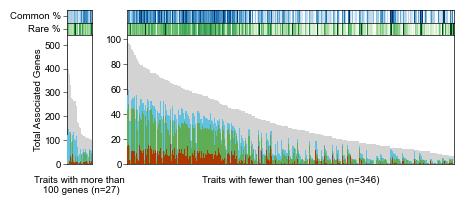

In [100]:
gene_split_results = gene_split_results.sort_values(by=['Total', 'overlap+RareCommonZ', 'Overlap'], ascending=False)

_, [[axc1, axc2], [axr1, axr2], [ax1, ax2]] = plt.subplots(nrows=3, ncols=2, figsize=(5, 2), gridspec_kw={'width_ratios':[27, 346],
                                                    'height_ratios':[1,1,10], 'hspace':0}, sharex='col')
sns.barplot(gene_split_results[gene_split_results.Total>100], x='trait_pair', y='Overlap', color='#af3800', 
    zorder=10,saturation=1, ax=ax1, width=1)
sns.barplot(gene_split_results[gene_split_results.Total>100], x='trait_pair', y='overlap+RareZ', color=green, 
    zorder=5, saturation=1, ax=ax1, width=1)
sns.barplot(gene_split_results[gene_split_results.Total>100], x='trait_pair', y='overlap+RareCommonZ', color=blue, 
    zorder=3, saturation=1, ax=ax1, width=1)
sns.barplot(gene_split_results[gene_split_results.Total>100], x='trait_pair', y='Total', color='lightgrey', 
    zorder=1, saturation=1, ax=ax1, width=1)


sns.barplot(gene_split_results[gene_split_results.Total<=100], x='trait_pair', y='Overlap', color='#af3800', 
    zorder=10,saturation=1, ax=ax2, width=1)
sns.barplot(gene_split_results[gene_split_results.Total<=100], x='trait_pair', y='overlap+RareZ', color=green, 
    zorder=5, saturation=1, ax=ax2, width=1)
sns.barplot(gene_split_results[gene_split_results.Total<=100], x='trait_pair', y='overlap+RareCommonZ', color=blue, 
    zorder=3, saturation=1, ax=ax2, width=1)
sns.barplot(gene_split_results[gene_split_results.Total<=100], x='trait_pair', y='Total', color='lightgrey', 
    zorder=1, saturation=1, ax=ax2, width=1)
ax2.set_xticks([])
ax2.set_ylabel('')


sns.heatmap(gene_split_results[gene_split_results.Total<=100][['C_frac']].T, cmap='Blues', vmin=0, vmax=1, 
ax=axc2, cbar=False)
sns.heatmap(gene_split_results[gene_split_results.Total>100][['C_frac']].T, cmap='Blues', vmin=0, vmax=1, 
ax=axc1, cbar=False)

sns.heatmap(gene_split_results[gene_split_results.Total<=100][['R_frac']].T, cmap='Greens', vmin=0, vmax=1, 
ax=axr2, cbar=False)
sns.heatmap(gene_split_results[gene_split_results.Total>100][['R_frac']].T, cmap='Greens', vmin=0, vmax=1, 
ax=axr1, cbar=False)

# Axis clean up
ax1.set_xticks([])
ax1.set_ylabel('Total Associated Genes')
ax2.set_xticks([])
ax2.set_ylabel('')
ax1.set_xlabel(f'\nTraits with more than\n 100 genes (n={len(gene_split_results[gene_split_results.Total>100])})')
ax2.set_xlabel(f'\nTraits with fewer than 100 genes (n={len(gene_split_results[gene_split_results.Total<=100])})')
axc1.set_yticks([0.5], labels=['Common %'], rotation=0)
axc2.set_yticks([])
axr1.set_yticks([0.5], labels=['Rare %'], rotation=0)
axr2.set_yticks([])
for ax in [axc1, axc2, axr1, axr2]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
ax1.set_xlim(-0.5, 26.5)
ax2.set_xlim(-0.5, 345.5)


In [101]:
print('% CVGs prioritized:', f'{100*gene_split_results.C_frac.mean():.2f}')
print('% RVGs prioritized:', f'{100*gene_split_results.R_frac.mean():.2f}')

% CVGs prioritized: 44.39
% RVGs prioritized: 42.02


## Figure 3F - Tissue Enrichments

In [110]:
def load_results(file_name, best_df, datadir):
    tiss_df = pd.read_csv(os.path.join(datadir, file_name), sep='\t')
    tiss_df = tiss_df.assign(Domain=tiss_df.GeneSet.map(best_df.set_index('trait_pair').Domain.to_dict()))
    tiss_df = tiss_df.assign(name=tiss_df.GeneSet.map(best_df.set_index('trait_pair')['Trait'].to_dict()))
    tiss_df['Domain']  = tiss_df.Domain.apply(lambda x: x.lower())
    tiss_df['log2FoldChange'] = np.log2(tiss_df['fold.change'])
    tiss_df['EFO'] = tiss_df.GeneSet.map(best_df.set_index('trait_pair')['EFO'].to_dict())
    return tiss_df

In [108]:
best_df = best_df.merge(info_df.loc[:, ('EFO', 'Domain')], on=['EFO'], how='left')

In [104]:
relevant_tissues = {
       'Renal': ['Kidney'], 
       'Immunological':['Appendix', 'Spleen', 'Tonsil'], 
       'Psychiatric' :['Cerebral Cortex'], 
       'Infection': [],
       'Cardiovascular': ['Heart Muscle'],
       'Gastrointestinal':['Colon', 'Duodenum', 'Esophagus', 'Gallbladder', 'Rectum', 'Small Intestine', 'Stomach'], 
       'Endocrine': ['Adrenal Gland', 'Pancreas', 'Thyroid Gland'], 
       'Reproductive': ['Cervix, uterine', 'Endometrium', 'Fallopian Tube', 'Ovary', 'Placenta', 'Prostate', 'Testis'],
       'Hematological':['Bone Marrow'], 
       'Metabolic': ['Liver', 'Pancreas'], 
       'Skeletal': [], 
       'Neurological': ['Cerebral Cortex'], 
       'Pain': [],
       'Anthropometric': ['Adipose Tissue'], 
       'EarNoseThroat': [], 
       'Respiratory': ['Lung'], 
       'Opthamological': [],
       'Neoplasm': [], 
       'Dermatological': ['Skin'], 
       'Other': [], 
       'Muscular':['Skeletal Muscle', 'Smooth Muscle'],
       'Lipid Measurment': ['Liver', 'Gallbladder'], 
       'Hepatic': ['Liver'] 
}

exclude_hpa = ['Infection', 'Skeletal', 'Pain', 'EarNoseThroat', 'Opthamological', 'Neoplasm', 'Other']

gtex_tissues = {
    
       'Renal': ['Kidney'], 
       'Immunological':['Appendix', 'Spleen', 'Tonsil'], 
       'Psychiatric' :['Brain', 'Nerve'], 
       'Infection': [],
       'Cardiovascular': ['Artery', 'Heart', 'Muscle'],
       'Gastrointestinal':['Colon', 'Esophagus', 'Small Intestine', 'Stomach'], 
       'Endocrine': ['Adrenal Gland', 'Pancreas', 'Thyroid', 'Pituitary'], 
       'Reproductive': ['Cervix Uteri', 'Ovary', 'Prostate', 'Testis', 'Uterus', 'Vagina'],
       'Hematological':[], 
       'Metabolic': ['Liver', 'Pancreas'], 
       'Skeletal': [], 
       'Neurological': ['Cerebral Cortex'], 
       'Pain': [],
       'Anthropometric': ['Adipose Tissue'], 
       'EarNoseThroat': [], 
       'Respiratory': ['Lung'], 
       'Opthamological': [],
       'Neoplasm': [], 
       'Dermatological': ['Skin'], 
       'Other': [], 
       'Muscular':['Muscle'],
       'Lipid Measurment': ['Liver'], 
       'Hepatic': ['Liver'] 
    
}

exclude_gtex = ['Infection', 'Hematological', 'Skeletal', 'Pain', 'EarNoseThroat', 'Opthamological', 'Neoplasm', 'Other']

In [112]:
t_net = load_results('All_nodes_TissEnrich_HPA.txt', best_df, os.path.join(datadir, 'outputs'))
t_shared = load_results('shared_nodes_TissEnrich_HPA.txt', best_df,os.path.join(datadir, 'outputs'))
t_prioritized = load_results('prioritized_nodes_TissEnrich_HPA.txt', best_df, os.path.join(datadir, 'outputs'))
t_inputs = load_results('input_nodes_TissEnrich_HPA.txt', best_df, os.path.join(datadir, 'outputs'))

/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [113]:
from tqdm import tqdm
def count_relevant_enrichments_by_domain(tiss1, domain, relevant_tissues):
    count_df = tiss1[tiss1.Domain==domain.lower()]
    all_efos = count_df.EFO.unique()
    count_df = count_df.dropna()
    count_df = count_df[(count_df.Log10PValue > -1 * np.log10(0.05)) & (count_df.log2FoldChange > 0) & (count_df.Tissue.isin(relevant_tissues[domain]))]
    if len(count_df) > 0:
        counts = count_df.EFO.value_counts().to_dict()
    else:
        counts = {}
    return counts, len(all_efos)

def get_efos_per_domain(tiss_df, relevant_tissues):
    domain_counts = {}
    for domain in relevant_tissues.keys():
        counts, all_efos = count_relevant_enrichments_by_domain(tiss_df, domain, relevant_tissues)
        domain_counts[domain] = all_efos
    return domain_counts


In [114]:
efo_counts = get_efos_per_domain(t_net, relevant_tissues)

In [115]:
def get_enriched_fractions(t_net, t_shared, t_inputs, t_prioritized, relevant_tissues, efo_counts, subset= None, names=['Colocalized Network', 'Shared Assoc.', 'All Assoc.', 'Prioritized Assoc.'], 
                           return_counts=False):
    results = {n: {} for n in names}
    for i,  df in enumerate([t_net, t_shared, t_inputs, t_prioritized]):
        if subset is not None:
            df = df[df.EFO.isin(subset)]
        for domain in tqdm(relevant_tissues.keys()):
            if len(relevant_tissues[domain]) > 0:
                counts, _ = count_relevant_enrichments_by_domain(df, domain, relevant_tissues)
                if efo_counts[domain] > 0:
                    if return_counts:
                        results[names[i]][domain] = len(counts)
                    else:
                        results[names[i]][domain] = len(counts)/efo_counts[domain]
    return results

In [116]:
results = get_enriched_fractions(t_net, t_shared, t_inputs, t_prioritized, relevant_tissues, efo_counts)

100%|██████████| 23/23 [00:00<00:00, 724.68it/s]


In [117]:
def plot_frac4(results):
    plot_df = pd.DataFrame(results).reset_index(names='Domain').melt(id_vars='Domain', var_name='Set', value_name='Frac')
    order = pd.DataFrame(results).sort_values(by='Colocalized Network', ascending=False).index
    _ = plt.figure(figsize=(2.5, 1))
    sns.barplot(plot_df, x='Domain', y='Frac', hue='Set', hue_order=['Colocalized Network','Prioritized Assoc.', 'All Assoc.' ,'Shared Assoc.'], 
                palette= ['#441F5D', '#8D3B72', '#F78154', '#AF3800'],  saturation=1, order=order, edgecolor='black')
    _ = plt.xticks(rotation=90, ha='right')
    plt.ylabel('Fraction of Traits')
    plt.xlabel('Relevant Tissue Enrichments by Domain')

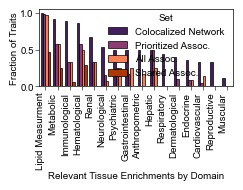

In [118]:
plot_frac4(results)

## SFig 1C - Network Repeats

In [119]:
coloc_df.columns

Index(['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',
       'Optimal COLOC', 'Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN', 'COLOC -logp HN',
       'Observed Size ST', 'Expected Size ST', 'Log2SizeOE ST',
       'COLOC Score ST', 'COLOC P ST', 'COLOC -logp ST', 'trait_pair'],
      dtype='object')

In [142]:
pc22 = coloc_df.dropna(subset='Observed Size PC22')
pc22 = pc22.loc[: , ['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network','Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'trait_pair']]
pc22.columns=  ['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network','Observed Size', 'Expected Size',
       'Log2SizeOE', 'COLOC Score', 'COLOC P',
       'COLOC -logp', 'trait_pair']
pc22['Network'] = 'pcnet2_2'

In [137]:
string = coloc_df.dropna(subset='Observed Size ST')
string = string.loc[: , ['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network','Observed Size ST', 'Expected Size ST',
       'Log2SizeOE ST', 'COLOC Score ST', 'COLOC P ST',
       'COLOC -logp ST', 'trait_pair']]
string.columns=  ['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network','Observed Size', 'Expected Size',
       'Log2SizeOE', 'COLOC Score', 'COLOC P',
       'COLOC -logp', 'trait_pair']
string['Network'] = 'stringHC'

In [138]:
humannet = coloc_df.dropna(subset='Observed Size HN')
humannet = humannet.loc[: , ['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network','Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN',
       'COLOC -logp HN', 'trait_pair']]
humannet.columns=  ['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network','Observed Size', 'Expected Size',
       'Log2SizeOE', 'COLOC Score', 'COLOC P',
       'COLOC -logp', 'trait_pair']
humannet['Network'] = 'humannet'

In [143]:
df2 = pd.concat([pc22, humannet, string])

In [135]:
df2.Network.unique()

array(['PCNet2.0'], dtype=object)

In [144]:
all_compare = best_df.loc[:, ( 'trait_pair', 'Log2SizeOE', 'COLOC -logp')].merge(df2[df2.Network=='pcnet2_2'].loc[:, ('trait_pair', 'Log2SizeOE', 'COLOC -logp')],
                                                                              on='trait_pair', suffixes=['', '22'], how='left')
all_compare = all_compare.merge(df2[df2.Network=='humannet'].loc[:, ('trait_pair', 'Log2SizeOE', 'COLOC -logp')],
                               on='trait_pair', suffixes=['', 'HN'], how='left')
all_compare = all_compare.merge(df2[df2.Network=='stringHC'].loc[:, ('trait_pair', 'Log2SizeOE', 'COLOC -logp')],
                               on='trait_pair', suffixes=['', 'ST'], how='left')

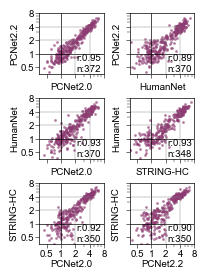

In [146]:
_, [[ax1, ax4],[ax2, ax5], [ax3,ax6]] = plt.subplots(nrows=3, ncols=2, figsize=(2,3), sharex=False, sharey=False, gridspec_kw={'hspace':0.4, 'wspace':0.4})

nets = ['', '22', 'HN', 'ST']
net_names = {'':'PCNet2.0', '22':'PCNet2.2', 'HN':'HumanNet', 'ST': 'STRING-HC'}
R = all_compare.corr(method='spearman', numeric_only=True)

pairs = [('', '22'), ('', 'HN'), ('', 'ST'), ('HN', '22'), ('ST', 'HN'), ('22', 'ST')]
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
rs = []
for i, p in enumerate(pairs):
    ax = axs[i]
    n1=p[1]
    n2=p[0]
    sns.scatterplot(all_compare, x=f'Log2SizeOE{n2}', y=f'Log2SizeOE{n1}', s=3, ax=ax, color='#8D3B72', alpha=0.7, edgecolor=None)
    n = all_compare.loc[:, (f'Log2SizeOE{n2}', f'Log2SizeOE{n1}')].dropna().shape
    ax.vlines(x=0, ymin=-1.5, ymax=3,color='black', linewidth=0.5,)
    ax.hlines(y=0, xmin=-1.5, xmax=3,color='black', linewidth=0.5,)
    for x in [1, 2]:
        ax.vlines(x=x, ymin=-1.5, ymax=np.abs(x), color='grey', linewidth=0.3, linestyle='-')
        ax.hlines(y=x, xmin=-1.5, xmax=np.abs(x), color='grey', linewidth=0.3, linestyle='-')
    ax.set_xlim(-1.5, 3)
    ax.set_ylim(-1.5, 3)
    r = R.at[f'Log2SizeOE{n1}', f'Log2SizeOE{n2}']
    rs.append(r)
    ax.text(1.1, -1.3, s=f'r:{r:.2f}\nn:{n[0]}')
    ax.set_ylabel(net_names[n1])
    ax.set_xlabel(net_names[n2])
    if i <3:
        ax.set_yticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
        _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
    else:
        ax.set_yticks([-1, 0, 1, 2, 3], labels=[])
        _ = ax.set_yticks(np.log2([3,5,6, 7]), minor=True)
    if i in [2,5]:
        ax.set_xticks([-1, 0, 1, 2, 3], labels=[0.5, 1, 2, 4, 8])
        _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)
    else:
        ax.set_xticks([-1, 0, 1, 2, 3], labels=[])
        _ = ax.set_xticks(np.log2([3,5,6, 7]), minor=True)


In [147]:
print('Mean correlation:',  np.mean(rs))

Mean correlation: 0.9194813395404345
